In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from pathlib import Path

# Import some useful functions from adabmDCA
from adabmDCA.fasta import get_tokens
from adabmDCA.utils import get_device, get_dtype, get_mask_save
from adabmDCA.io import save_params, save_chains
from adabmDCA.stats import get_freq_single_point, get_freq_two_points, get_correlation_two_points
#from arDCA.model import arDCA
from adabmDCA.dataset import DatasetDCA
from arDCA import arDCA

In [2]:
# Set the device
device = get_device("cuda")
dtype = get_dtype("float32")

Running on NVIDIA RTX A5000


In [3]:
output_folder = "/home/lorenzo/Documents/arDCA/output"
folder = Path(output_folder)
folder.mkdir(parents=True, exist_ok=True)

# Label for the ouput files
label = "arDCA"

# Paths for the output files
path_params = folder / Path(f"{label}_params.dat")
path_chains = folder / Path(f"{label}_chains.fasta")

In [4]:
# Select the alphabet correspondig to RNA sequences
tokens = get_tokens("protein")
path_data = "/home/lorenzo/Documents/data/PF00072/PF00072.fasta"
dataset = DatasetDCA(
    path_data=path_data,
    alphabet="protein",
    device=device,
    dtype=dtype,
)
M, L, q = len(dataset), dataset.get_num_residues(), dataset.get_num_states()

Automatically computing the sequence weights...
Multi-sequence alignment imported: M = 49527, L = 112, q = 21, M_eff = 42985.


In [5]:
msa_oh = nn.functional.one_hot(dataset.data.to(torch.long), num_classes=q).to(dtype=dtype)
# Set the random seed
torch.manual_seed(0)

In [6]:
pseudocount = 0.01#1 / dataset.get_effective_size()
fi_target = get_freq_single_point(data=msa_oh, weights=dataset.weights, pseudo_count=pseudocount)
fij_target = get_freq_two_points(data=msa_oh, weights=dataset.weights, pseudo_count=pseudocount)

In [151]:
# Initialize the model
model = arDCA(L=L, q=q).to(device=device, dtype=dtype)

In [152]:
# Hyperparameters
lr = 0.005
max_epochs = 1000
epsconv = 1e-5
reg_h = 1e-6
reg_J = 1e-2

In [153]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [154]:
model.fit(
    X=msa_oh,
    weights=dataset.weights,
    pseudo_count=pseudocount,
    optimizer=optimizer,
    max_epochs=max_epochs,
    use_entropic_order=True,
    reg_h=reg_h,
    reg_J=reg_J,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [161]:
from adabmDCA.pca import Pca
from adabmDCA.plot import plot_PCA
from adabmDCA.utils import resample_sequences

In [164]:
pca = Pca()
resampled_sequences = resample_sequences(msa_oh, dataset.weights, nextract=10000)
data_proj = pca.fit_transform(resampled_sequences.view(10000, -1), num_directions=3)

In [165]:
samples = model.sample(n_samples=10000)
samples_proj = pca.transform(samples.view(10000, -1))

In [166]:
data_proj = data_proj.cpu().numpy()
samples_proj = samples_proj.cpu().numpy()

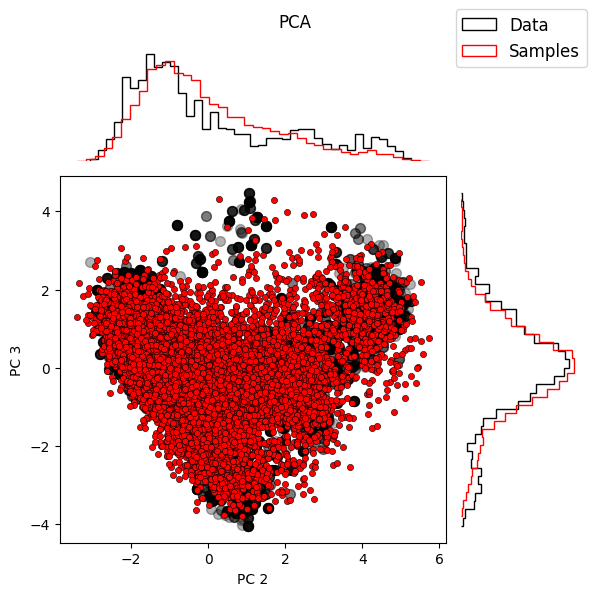

In [167]:
fig = plt.figure(figsize=(6,6))
fig = plot_PCA(
    fig=fig,
    data1=data_proj,
    data2=samples_proj,
    pc1=1,
    pc2=2,
    labels=["Data", "Samples"],
    title="PCA",
)
fig.tight_layout()

In [168]:
pi = get_freq_single_point(samples)
pij = get_freq_two_points(samples)
pearson, slope = get_correlation_two_points(fi=fi_target, fij=fij_target, pi=pi, pij=pij)
print(f"Pearson: {pearson:.2f}, slope: {slope:.2f}")

Pearson: 0.96, slope: 0.66


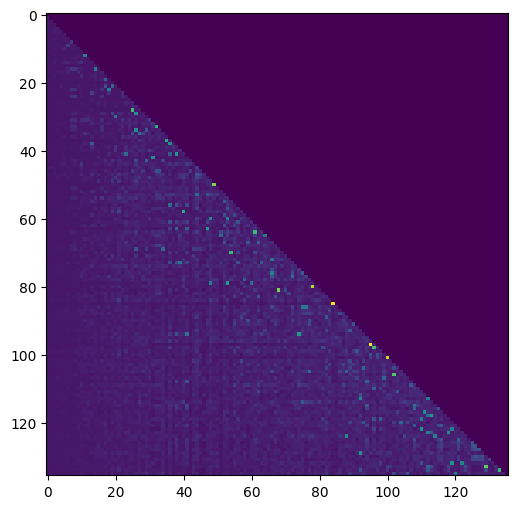

In [169]:
F = model.J.square().sum(dim=(1, 3)).sqrt().detach().cpu().numpy()
plt.figure(figsize=(6, 6))
plt.imshow(F, cmap="viridis")

In [17]:
model = arDCA(L=L, q=q).to(device=device, dtype=dtype)

In [18]:
model.load("/home/lorenzo/Documents/models/PF00072/arDCA_params.dat", tokens=tokens)

In [19]:
# Sample from the model
samples = model.sample(n_samples=10000)

In [20]:
pi = get_freq_single_point(samples)
pij = get_freq_two_points(samples)
pearson, slope = get_correlation_two_points(fi=fi_target, fij=fij_target, pi=pi, pij=pij)
print(f"Pearson: {pearson:.2f}, slope: {slope:.2f}")

Pearson: 0.01, slope: 0.01


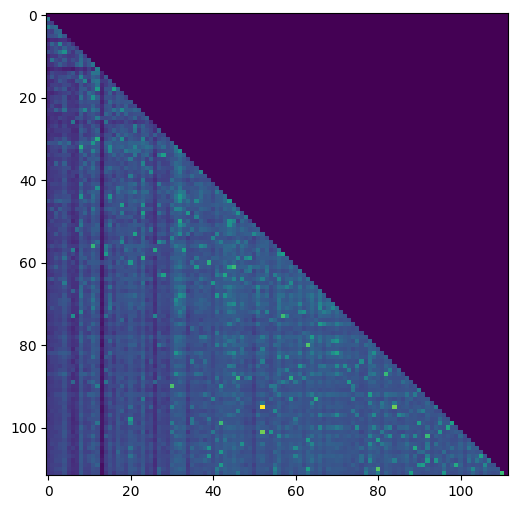

In [21]:
F = model.J.square().sum(dim=(1, 3)).sqrt().detach().cpu().numpy()
plt.figure(figsize=(6, 6))
plt.imshow(F, cmap="viridis")

In [22]:
# load parameters from pytorch file
path = "/home/lorenzo/Documents/models/PF00072/model.pth"
params = torch.load(path, map_location=device)

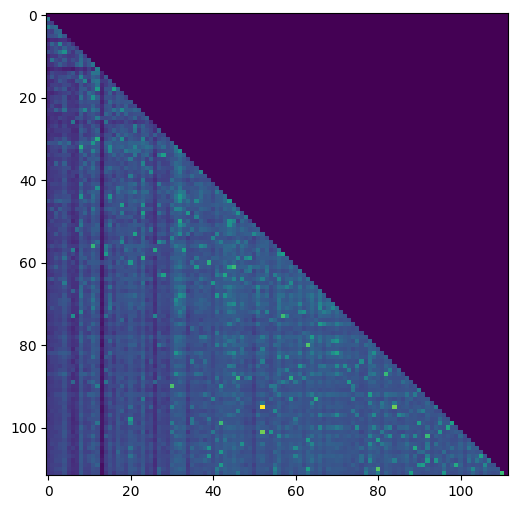

In [26]:
F = params["J"].square().sum(dim=(1, 3)).sqrt().detach().cpu().numpy()
plt.figure(figsize=(6, 6))
plt.imshow(F, cmap="viridis")

In [31]:
model.load_state_dict(params)
samples = model.sample(n_samples=10000)
pi = get_freq_single_point(samples)
pij = get_freq_two_points(samples)
pearson, slope = get_correlation_two_points(fi=fi_target, fij=fij_target, pi=pi, pij=pij)
print(f"Pearson: {pearson:.2f}, slope: {slope:.2f}")

Pearson: 0.01, slope: 0.01
